In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import glob
from tqdm.notebook import trange, tqdm
import json
import re
import pandas as pd
import numpy as np
from collections import defaultdict

from utills import chunker, cartesian_product, get_num_chunks
from train_utils import generate_unique_pairs, get_random_author_excluding, generate_doc_pairs, fit_transformers, vectorize


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [3]:

from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
chunk_sz=20
TEMP_DATA = '../temp_data/reddit/multidoc_' + str(chunk_sz) + '/'

In [5]:
with open(COMPUTED_DATA_PATH + 'metadata.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

Vectorize Data
===

In [6]:
transformer, scaler, secondary_scaler = fit_transformers(
    COMPUTED_DATA_PATH + 'train.jsonl', 
    author_mapping, 
    chunk_sz, 
    sample_fraction=0.05
)

Sampled: 5040
Reading preprocessed data...



Fitting transformer
Generating pairs


In [7]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((transformer, scaler, secondary_scaler ), f)

In [8]:
XX_train, author_bounds, author_subreddit, x_shape = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'train.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_train_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [9]:
XX_test, author_bounds_test, author_subreddit_test, x_shape_test = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'test.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_test_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [10]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((author_bounds, author_bounds_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test), f)

Train the classifier
===

In [11]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_bounds.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u

subreddit_to_author = defaultdict(list)
for k, v in author_subreddit.items():
    subreddit_to_author[v].append(k)

    
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_bounds_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

subreddit_to_author_test = defaultdict(list)
for k, v in author_subreddit_test.items():
    subreddit_to_author_test[v].append(k)

X_idxs_train, Y_train = generate_doc_pairs(author_mapping, subreddit_to_author, author_to_root, author_bounds, author_subreddit)
X_idxs_test, Y_test = generate_doc_pairs(author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)




In [12]:
len(Y_train), Y_train.mean()

(7553329, 0.5000000661959779)

In [13]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((
        author_bounds, 
        author_bounds_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ), f)

In [14]:
batch_sz = 50000
clf = SGDClassifier(loss='log', alpha=0.01)
x_test_diff_sample = secondary_scaler.transform(np.abs(XX_test[X_idxs_test[:batch_sz, 0]] - XX_test[X_idxs_test[:batch_sz, 1]]))
y_test_sample = Y_test[:batch_sz]
aucs = []
for i in range(100):
    for idxs in chunker(np.arange(len(X_idxs_train)), batch_sz):
        x_diff = secondary_scaler.transform(np.abs(XX_train[X_idxs_train[idxs, 0]] - XX_train[X_idxs_train[idxs, 1]]))
        x_diff[np.isnan(x_diff)]=0
        y = Y_train[idxs]
        clf.partial_fit(x_diff, y, classes=[0, 1])

        probs = clf.predict_proba(x_test_diff_sample)[:, 1]

        fpr, tpr, thresh = roc_curve(y_test_sample, probs)
        roc_auc = auc(fpr, tpr)
        print('AUC:', roc_auc)
    print('~'*20, 'Epoch: ', i)
    aucs.append(roc_auc)

AUC: 0.7981746427083177
AUC: 0.8265492764899154
AUC: 0.8278020804979332
AUC: 0.8369149997562559
AUC: 0.8423791685912269
AUC: 0.850869370245564
AUC: 0.8528344494581406
AUC: 0.8611422423113103
AUC: 0.8629563607229207
AUC: 0.8663317703445234
AUC: 0.8632470903247813
AUC: 0.8697882487666448
AUC: 0.8706146967719339
AUC: 0.872597503984624
AUC: 0.8737180711917957
AUC: 0.8753594616023005
AUC: 0.8754990072031936
AUC: 0.8760049400064317
AUC: 0.8774680552157955
AUC: 0.8779414040188251
AUC: 0.8789794936254687
AUC: 0.880629381636028
AUC: 0.8808370152373569
AUC: 0.8803222456340624
AUC: 0.8809998584383991
AUC: 0.8825020992480135
AUC: 0.8824934608479582
AUC: 0.8820832968453332
AUC: 0.8817861312434313
AUC: 0.8833243160532755
AUC: 0.8844135464602467
AUC: 0.8831707096522926
AUC: 0.8844476520604649
AUC: 0.8824553384477141
AUC: 0.8835129384544829
AUC: 0.885327668066097
AUC: 0.8849339096635771
AUC: 0.88534687286622
AUC: 0.8857898168690548
AUC: 0.8852150376653763
AUC: 0.8859197448698863
AUC: 0.885677037668333

AUC: 0.8929857305151088
AUC: 0.8928989785145534
AUC: 0.8929066265146024
AUC: 0.8928016041139304
AUC: 0.8929217993146996
AUC: 0.8929708649150137
AUC: 0.8929095945146215
AUC: 0.8926308601128374
AUC: 0.8924598745117431
AUC: 0.8926028425126582
AUC: 0.8924717705118193
AUC: 0.8926632137130446
AUC: 0.8926485705129507
AUC: 0.8925077353120495
AUC: 0.8928299369141116
AUC: 0.8927496489135979
AUC: 0.8926204553127709
AUC: 0.892748135313588
AUC: 0.8927361129135112
AUC: 0.8928772489144143
AUC: 0.8927495209135969
AUC: 0.8928526441142568
AUC: 0.892922157714702
AUC: 0.8927891737138507
AUC: 0.8929329929147711
AUC: 0.8925976153126248
AUC: 0.8925945673126052
AUC: 0.8926718377130999
AUC: 0.8928958809145335
AUC: 0.8930660825156229
AUC: 0.8930283481153813
AUC: 0.8931185049159585
AUC: 0.8927516649136106
AUC: 0.8927773929137752
AUC: 0.8929474521148637
AUC: 0.8928627385143215
AUC: 0.8927821289138056
AUC: 0.8926197081127661
AUC: 0.8927851817138251
AUC: 0.8928501209142408
AUC: 0.8927768377137718
AUC: 0.89274363291

AUC: 0.8930954073158106
AUC: 0.8931516025161703
AUC: 0.8932017321164911
AUC: 0.8931171769159498
AUC: 0.8931029369158587
AUC: 0.8932386921167277
AUC: 0.8931432073161165
AUC: 0.8931388377160886
AUC: 0.8932543833168282
AUC: 0.8932115321165539
AUC: 0.8931687209162797
AUC: 0.8932785545169828
AUC: 0.8933025481171363
AUC: 0.8932214729166175
AUC: 0.8933038281171446
AUC: 0.8932097705165425
AUC: 0.8931747097163183
AUC: 0.8932140921165702
AUC: 0.8931695737162851
AUC: 0.8931167225159471
AUC: 0.8930602361155856
AUC: 0.8932243273166357
AUC: 0.8931046361158697
AUC: 0.8931947417164462
AUC: 0.8933408105173812
AUC: 0.8932616793168746
AUC: 0.8932843049170196
AUC: 0.8931437033161196
AUC: 0.8932634025168857
AUC: 0.8932560201168387
AUC: 0.8932711609169354
AUC: 0.8932655545168996
AUC: 0.8932722793169426
AUC: 0.8932605497168675
AUC: 0.8931529033161786
AUC: 0.8932185833165989
AUC: 0.8932536377168232
AUC: 0.8932325785166885
AUC: 0.8932382025167245
AUC: 0.8931611673162315
AUC: 0.8932316217166825
AUC: 0.893233293

AUC: 0.8933343177173398
AUC: 0.8932934761170782
AUC: 0.8932958809170938
AUC: 0.8933077017171692
AUC: 0.8933624633175199
AUC: 0.8933669977175489
AUC: 0.8933895945176934
AUC: 0.8933433961173977
AUC: 0.8933236937172716
AUC: 0.8933666777175467
AUC: 0.8933856377176681
AUC: 0.8933938281177205
AUC: 0.8934398009180148
AUC: 0.8934100089178241
AUC: 0.8934408761180216
AUC: 0.8933721161175815
AUC: 0.8933936873177196
AUC: 0.8933388649173687
AUC: 0.8934178377178742
AUC: 0.8933761305176071
AUC: 0.8934080921178118
AUC: 0.893380316117634
AUC: 0.8934472073180622
AUC: 0.8934776969182572
AUC: 0.8935471337187016
AUC: 0.8935550649187525
AUC: 0.8935607881187891
AUC: 0.8935838185189365
AUC: 0.8936825033195681
AUC: 0.8936106569191081
AUC: 0.893600304919042
AUC: 0.8936219881191807
AUC: 0.8936163737191447
AUC: 0.8936335737192548
AUC: 0.8935816089189224
AUC: 0.893592520918992
AUC: 0.893613898519129
AUC: 0.8936406521193002
AUC: 0.893567639318833
AUC: 0.8935611801187915
AUC: 0.893549074518714
~~~~~~~~~~~~~~~~~~~~ E

AUC: 0.8936530393193796
AUC: 0.8936526841193771
AUC: 0.8935999753190398
AUC: 0.8935914233189851
AUC: 0.893580464918915
~~~~~~~~~~~~~~~~~~~~ Epoch:  8
AUC: 0.8935804025189146
AUC: 0.893662176919438
AUC: 0.8936570297194051
AUC: 0.8936536841193836
AUC: 0.8936541673193865
AUC: 0.8935948201190069
AUC: 0.8936219561191805
AUC: 0.8936153993191386
AUC: 0.8936302777192338
AUC: 0.8936310457192387
AUC: 0.8936128185191221
AUC: 0.8935883881189657
AUC: 0.893567975318835
AUC: 0.893624695319198
AUC: 0.8935710361188546
AUC: 0.8935584553187742
AUC: 0.8935909961189823
AUC: 0.893586877718956
AUC: 0.8936268345192118
AUC: 0.8935745977188775
AUC: 0.8935878537189624
AUC: 0.8936516057193702
AUC: 0.8936598505194231
AUC: 0.8936329945192512
AUC: 0.8935858473189494
AUC: 0.8936660185194625
AUC: 0.8936196777191661
AUC: 0.8936766329195305
AUC: 0.8936347177192622
AUC: 0.8936473721193433
AUC: 0.8936835657195747
AUC: 0.893637034519277
AUC: 0.8935780313188995
AUC: 0.8935163673185048
AUC: 0.8934623449181589
AUC: 0.89354014

AUC: 0.8936379689192829
AUC: 0.8936013033190484
AUC: 0.8935625273188003
AUC: 0.8935155513184996
AUC: 0.893569520918845
AUC: 0.8935199545185277
AUC: 0.8935938969190008
AUC: 0.893589533718973
AUC: 0.8935785401189026
AUC: 0.8935906633189803
AUC: 0.8936194361191643
AUC: 0.8936309705192383
AUC: 0.8935813161189203
AUC: 0.8935561673187595
AUC: 0.8934763881182488
AUC: 0.893486085718311
AUC: 0.8934232921179092
AUC: 0.8935103161184661
AUC: 0.8934960905183751
AUC: 0.8934436537180395
AUC: 0.8935199257185275
AUC: 0.893496709718379
AUC: 0.8935022873184146
AUC: 0.8935388729186489
AUC: 0.8935252633185616
AUC: 0.8935256265185639
AUC: 0.8934900825183366
AUC: 0.8935292777185875
AUC: 0.893531072918599
AUC: 0.8935104905184672
AUC: 0.8935317417186031
AUC: 0.8934706745182124
AUC: 0.8934285065179424
AUC: 0.8934522985180946
AUC: 0.8935015209184097
AUC: 0.893548573718711
AUC: 0.8935475673187044
AUC: 0.893547978518707
AUC: 0.8934743897182361
AUC: 0.8934273433179349
AUC: 0.8934971641183819
AUC: 0.8934991737183948

AUC: 0.8935639625188094
AUC: 0.8934914409183452
AUC: 0.8934499705180798
AUC: 0.8935176185185126
AUC: 0.8935224265185435
AUC: 0.8934750921182406
AUC: 0.8934499385180796
AUC: 0.8934504409180828
AUC: 0.8934577193181293
AUC: 0.893440464918019
AUC: 0.8934406841180205
AUC: 0.8934525369180962
AUC: 0.8934429945180352
AUC: 0.8934559945181184
AUC: 0.8935176009185125
AUC: 0.8935083833184537
AUC: 0.8935016857184108
AUC: 0.893535607318628
AUC: 0.8935545657187492
AUC: 0.8935489033187131
AUC: 0.8935482073187085
AUC: 0.8935310681185987
AUC: 0.8935223241185428
AUC: 0.8935166953185069
AUC: 0.8935028857184184
AUC: 0.8934665961181862
AUC: 0.893453610518103
AUC: 0.8935059801184383
AUC: 0.8934738249182324
AUC: 0.8934623289181589
AUC: 0.8935408425186614
AUC: 0.8935337817186162
AUC: 0.893524367318556
AUC: 0.8934896409183337
AUC: 0.8935193849185241
AUC: 0.8935143145184916
AUC: 0.8935019977184129
AUC: 0.8934935529183587
AUC: 0.8934789193182652
AUC: 0.8934734009182298
AUC: 0.8934383561180055
AUC: 0.8934604041181

AUC: 0.8935122729184786
AUC: 0.8934984249183899
AUC: 0.893489383318332
AUC: 0.893455789718117
AUC: 0.8934630297181634
AUC: 0.8934902793183379
AUC: 0.8934981065183879
AUC: 0.8934780233182593
AUC: 0.8934544553181085
AUC: 0.8934685097181985
AUC: 0.8935020057184129
AUC: 0.8935225769185443
AUC: 0.8935303945185946
AUC: 0.8935139385184893
AUC: 0.8935038185184244
AUC: 0.8935199913185279
AUC: 0.8935215865185382
AUC: 0.8935355785186277
AUC: 0.8935611849187917
AUC: 0.8935472441187022
AUC: 0.8935488473187126
AUC: 0.893531392918601
AUC: 0.8935250649185604
AUC: 0.8935094713184606
AUC: 0.8935155993184999
AUC: 0.8934837465182959
AUC: 0.893510464918467
AUC: 0.8935086297184552
AUC: 0.8935447113186862
AUC: 0.8935468697187
AUC: 0.8935921241189897
AUC: 0.893601407319049
AUC: 0.8935864121189531
AUC: 0.8936038569190646
AUC: 0.8936663337194646
AUC: 0.8936390857192901
AUC: 0.8936363785192728
AUC: 0.8936488473193526
AUC: 0.8936638121194483
AUC: 0.8936664681194655
AUC: 0.893639528919293
AUC: 0.8936326185192487
A

AUC: 0.8936528857193785
AUC: 0.8936592057194188
AUC: 0.8936653161194581
AUC: 0.89364687451934
AUC: 0.8936343577192598
AUC: 0.8936516153193704
AUC: 0.8936666041194662
AUC: 0.8936398249192947
AUC: 0.8936376921192812
AUC: 0.8936314457192414
~~~~~~~~~~~~~~~~~~~~ Epoch:  17
AUC: 0.8936302681192336
AUC: 0.8936709145194939
AUC: 0.893679386519548
AUC: 0.8936716793194988
AUC: 0.8936717657194992
AUC: 0.8936260489192067
AUC: 0.8936472601193424
AUC: 0.8936512953193683
AUC: 0.89365468411939
AUC: 0.8936609657194301
AUC: 0.8936509513193661
AUC: 0.8936351033192647
AUC: 0.8936315449192419
AUC: 0.893657032919405
AUC: 0.8936273081192149
AUC: 0.8936122377191184
AUC: 0.8936276041192166
AUC: 0.8936215897191783
AUC: 0.8936407801193009
AUC: 0.8936211193191752
AUC: 0.8936388281192885
AUC: 0.8936658537194614
AUC: 0.8936644969194527
AUC: 0.8936483401193495
AUC: 0.8936225433191843
AUC: 0.8936626729194412
AUC: 0.8936417865193074
AUC: 0.8936842681195794
AUC: 0.8936717865194996
AUC: 0.8936808089195571
AUC: 0.8936973

AUC: 0.893658292119413
AUC: 0.8936372761192785
AUC: 0.8936774825195359
AUC: 0.8936677145194734
AUC: 0.8936756857195245
AUC: 0.8936928505196342
AUC: 0.8936633609194455
AUC: 0.8936398569192952
AUC: 0.8936073801190874
AUC: 0.8935817001189229
AUC: 0.8936134585191261
AUC: 0.893590928918982
AUC: 0.8936216521191785
AUC: 0.8936242873191954
AUC: 0.8936146601191337
AUC: 0.893620927319174
AUC: 0.8936386761192876
AUC: 0.8936604121194266
AUC: 0.8936379433192829
AUC: 0.8936173145191509
AUC: 0.8935659065188217
AUC: 0.8935758729188856
AUC: 0.8935378761186423
AUC: 0.8935814473189212
AUC: 0.8935748073188787
AUC: 0.8935483241187093
AUC: 0.8935956713190123
AUC: 0.8935836889189356
AUC: 0.8935803721189144
AUC: 0.8936032169190605
AUC: 0.8935971593190218
AUC: 0.8935898121189747
AUC: 0.8935756425188841
AUC: 0.8936033129190613
AUC: 0.8935997209190383
AUC: 0.8935859129189498
AUC: 0.8935975641190244
AUC: 0.8935686137188391
AUC: 0.8935388281186485
AUC: 0.893544047318682
AUC: 0.8935676425188328
AUC: 0.8935973977190

AUC: 0.8935755785188837
AUC: 0.8935468521187
AUC: 0.8935500569187205
AUC: 0.8935805209189154
AUC: 0.893607954519091
AUC: 0.8936043401190678
AUC: 0.8936050873190726
AUC: 0.8935697833188465
AUC: 0.8935396153186537
AUC: 0.8935690089188416
AUC: 0.8935717449188592
AUC: 0.8935416089186663
AUC: 0.8935185993185191
AUC: 0.8935090297184578
AUC: 0.8935151481184971
AUC: 0.8935019353184124
AUC: 0.8935078569184502
AUC: 0.8935154729184992
AUC: 0.8935112409184719
AUC: 0.8935099833184639
AUC: 0.8935526265187369
AUC: 0.8935541833187467
AUC: 0.8935550857187525
AUC: 0.8935807081189167
AUC: 0.893590319318978
AUC: 0.8935896649189738
AUC: 0.8935837065189357
AUC: 0.8935752473188816
AUC: 0.8935677433188336
AUC: 0.893562991318803
AUC: 0.893554508118749
AUC: 0.893535464918627
AUC: 0.8935296585185899
AUC: 0.8935672569188304
AUC: 0.8935457945186931
AUC: 0.893522335318543
AUC: 0.8935752121188814
AUC: 0.8935769337188924
AUC: 0.8935773321188949
AUC: 0.89355155931873
AUC: 0.8935708953188537
AUC: 0.8935637017188077
AUC

AUC: 0.8935831417189322
AUC: 0.8935852745189456
AUC: 0.8935605513187875
AUC: 0.8935754073188826
AUC: 0.8935697049188461
AUC: 0.893567658518833
AUC: 0.8935599561187837
AUC: 0.8935465113186977
AUC: 0.8935375001186399
AUC: 0.8935133209184851
AUC: 0.89352343931855
AUC: 0.8935339929186176
AUC: 0.8935405609186596
AUC: 0.8935339705186175
AUC: 0.8935062873184403
AUC: 0.8935147497184944
AUC: 0.8935398089186548
AUC: 0.8935592025187789
AUC: 0.8935651113188169
AUC: 0.8935603049187859
AUC: 0.8935528537187383
AUC: 0.893561869718796
AUC: 0.8935678617188343
AUC: 0.8935743673188759
AUC: 0.8935909657189822
AUC: 0.8935790665189061
AUC: 0.8935829641189308
AUC: 0.8935708297188534
AUC: 0.8935677657188337
AUC: 0.8935506041187238
AUC: 0.8935494409187165
AUC: 0.8935285593185828
AUC: 0.8935380665186436
AUC: 0.8935363817186329
AUC: 0.8935699625188477
AUC: 0.8935696217188456
AUC: 0.893597346519023
AUC: 0.8936108233191093
AUC: 0.8936094377191005
AUC: 0.8936203289191702
AUC: 0.8936567913194035
AUC: 0.89363970171929

AUC: 0.8936135785191269
AUC: 0.893610789719109
AUC: 0.8936186537191593
AUC: 0.8936532729193809
AUC: 0.8936389945192895
AUC: 0.8936276953192173
AUC: 0.8936420409193091
AUC: 0.8936448121193268
AUC: 0.8936525209193762
AUC: 0.8936398681192951
AUC: 0.893632037719245
AUC: 0.8936414297193052
AUC: 0.8936537977193844
AUC: 0.8936396105192935
AUC: 0.8936393961192922
AUC: 0.8936353401192663
~~~~~~~~~~~~~~~~~~~~ Epoch:  26
AUC: 0.8936396089192935
AUC: 0.8936658121194612
AUC: 0.8936683753194776
AUC: 0.8936625561194402
AUC: 0.893662351319439
AUC: 0.8936298345192311
AUC: 0.8936427993193139
AUC: 0.8936444633193246
AUC: 0.8936520905193733
AUC: 0.8936609401194301
AUC: 0.8936542681193873
AUC: 0.8936413897193048
AUC: 0.8936405385192995
AUC: 0.8936591081194184
AUC: 0.8936396153192935
AUC: 0.8936264969192096
AUC: 0.8936352729192658
AUC: 0.8936265801192101
AUC: 0.8936382137192846
AUC: 0.8936254953192032
AUC: 0.8936363865192729
AUC: 0.8936532377193808
AUC: 0.8936539593193853
AUC: 0.893645618519332
AUC: 0.89362

AUC: 0.8936263753192089
AUC: 0.8936355817192677
AUC: 0.8936496617193579
AUC: 0.8936495065193568
AUC: 0.8936449721193278
AUC: 0.8936260969192071
AUC: 0.8936509737193663
AUC: 0.893636567319274
AUC: 0.8936650441194564
AUC: 0.893661573719434
AUC: 0.893667352919471
AUC: 0.8936828729195704
AUC: 0.893662188119438
AUC: 0.8936413769193048
AUC: 0.8936213897191769
AUC: 0.8935998265190388
AUC: 0.8936263161192084
AUC: 0.8936068889190841
AUC: 0.8936308041192371
AUC: 0.8936304201192349
AUC: 0.8936245017191968
AUC: 0.8936251161192008
AUC: 0.8936387401192879
AUC: 0.8936529193193786
AUC: 0.8936359401192701
AUC: 0.8936234969191903
AUC: 0.8935954121190106
AUC: 0.8935988457190325
AUC: 0.8935726985188652
AUC: 0.8936055609190756
AUC: 0.8936005529190435
AUC: 0.8935836953189356
AUC: 0.8936149049191353
AUC: 0.8936046489190697
AUC: 0.893603594519063
AUC: 0.8936228169191862
AUC: 0.8936191849191628
AUC: 0.8936172873191506
AUC: 0.8936013193190485
AUC: 0.8936240057191936
AUC: 0.8936197881191666
AUC: 0.89360645691908

AUC: 0.8936183817191576
AUC: 0.8936064297190811
AUC: 0.893627036119213
AUC: 0.8936234121191898
AUC: 0.8936123129191188
AUC: 0.8936207385191728
AUC: 0.8936011113190471
AUC: 0.8935807065189165
AUC: 0.8935817033189228
AUC: 0.8935983737190296
AUC: 0.8936187513191599
AUC: 0.8936175241191521
AUC: 0.8936149817191358
AUC: 0.8935878393189621
AUC: 0.8935685209188384
AUC: 0.8935906873189803
AUC: 0.8935946553190057
AUC: 0.8935716249188586
AUC: 0.8935532281187408
AUC: 0.893541868118668
AUC: 0.8935454761186911
AUC: 0.8935342841186195
AUC: 0.8935377401186415
AUC: 0.8935434553186782
AUC: 0.8935380441186435
AUC: 0.8935345865186213
AUC: 0.8935672409188302
AUC: 0.8935718873188602
AUC: 0.893572815318866
AUC: 0.8935913977189849
AUC: 0.8936005689190436
AUC: 0.8936041481190665
AUC: 0.8936013657190487
AUC: 0.8935936089189991
AUC: 0.8935909001189818
AUC: 0.8935899305189756
AUC: 0.8935814201189212
AUC: 0.8935637929188084
AUC: 0.8935578137187701
AUC: 0.8935857561189489
AUC: 0.8935720473188611
AUC: 0.893556743318

AUC: 0.8935667993188275
AUC: 0.8935620265187969
AUC: 0.8935878601189624
AUC: 0.8935752041188814
AUC: 0.8935569561187646
AUC: 0.8935906201189799
AUC: 0.8935941593190027
AUC: 0.8935973017190227
AUC: 0.893577946518899
AUC: 0.8935899017189752
AUC: 0.8935876345189608
AUC: 0.8935851065189447
AUC: 0.8935799561189117
AUC: 0.893569983318848
AUC: 0.8935635881188071
AUC: 0.8935434089186778
AUC: 0.8935492057187149
AUC: 0.8935558281187573
AUC: 0.8935622777187986
AUC: 0.8935557049187565
AUC: 0.8935362169186319
AUC: 0.8935420537186691
AUC: 0.8935602425187856
AUC: 0.8935774393188956
AUC: 0.8935822553189264
AUC: 0.8935793145189076
AUC: 0.8935746233188775
AUC: 0.8935824649189279
AUC: 0.8935869017189563
AUC: 0.8935943257190038
AUC: 0.8936030329190594
AUC: 0.8935954105190106
AUC: 0.8935977545190257
AUC: 0.8935902329189775
AUC: 0.8935873865189593
AUC: 0.8935738969188729
AUC: 0.8935664521188253
AUC: 0.8935485721187109
AUC: 0.8935543945187481
AUC: 0.8935575657187684
AUC: 0.8935813481189206
AUC: 0.89358233691

AUC: 0.8935557177187565
AUC: 0.8935595481187811
AUC: 0.8935629433188028
AUC: 0.8935831961189324
AUC: 0.8935844857189408
AUC: 0.8936058473190774
AUC: 0.893613914519129
AUC: 0.8936116185191143
AUC: 0.89361875131916
AUC: 0.8936483865193497
AUC: 0.893638282519285
AUC: 0.8936315257192418
AUC: 0.8936412185193039
AUC: 0.8936453673193303
AUC: 0.8936489545193533
AUC: 0.8936381977192844
AUC: 0.893632175319246
AUC: 0.8936414313193051
AUC: 0.8936517481193712
AUC: 0.8936393513192918
AUC: 0.8936406601193003
AUC: 0.8936382201192846
~~~~~~~~~~~~~~~~~~~~ Epoch:  35
AUC: 0.8936375705192805
AUC: 0.8936599481194236
AUC: 0.8936650873194565
AUC: 0.8936574585194077
AUC: 0.8936570569194051
AUC: 0.8936312233192398
AUC: 0.8936418057193076
AUC: 0.8936433849193177
AUC: 0.8936479353193467
AUC: 0.8936559209193979
AUC: 0.8936517801193715
AUC: 0.893642980119315
AUC: 0.8936388921192889
AUC: 0.8936536857193835
AUC: 0.8936406809193005
AUC: 0.8936285433192227
AUC: 0.8936353961192665
AUC: 0.8936288713192249
AUC: 0.8936348

AUC: 0.8936414873193055
AUC: 0.893629212119227
AUC: 0.8936346313192617
AUC: 0.8936281513192201
AUC: 0.8936348761192632
AUC: 0.8936275353192162
AUC: 0.8936331481192522
AUC: 0.8936461481193354
AUC: 0.8936461737193355
AUC: 0.8936395161192929
AUC: 0.8936265833192103
AUC: 0.8936444569193247
AUC: 0.8936332601192529
AUC: 0.893654367319388
AUC: 0.8936528617193784
AUC: 0.8936607017194285
AUC: 0.8936749497195198
AUC: 0.8936566537194026
AUC: 0.8936405577192997
AUC: 0.8936242809191954
AUC: 0.8936088089190963
AUC: 0.8936296441192297
AUC: 0.8936127145191215
AUC: 0.8936294377192284
AUC: 0.8936292809192274
AUC: 0.8936261369192072
AUC: 0.8936252809192018
AUC: 0.8936362553192719
AUC: 0.8936479209193466
AUC: 0.8936356761192683
AUC: 0.8936239257191931
AUC: 0.8936038937190649
AUC: 0.8936062681190801
AUC: 0.893585466518947
AUC: 0.8936101065191047
AUC: 0.8936081929190924
AUC: 0.8935951241190089
AUC: 0.8936196953191661
AUC: 0.893607957719091
AUC: 0.893609820119103
AUC: 0.8936289241192252
AUC: 0.89362586651920

AUC: 0.8936216201191785
AUC: 0.8936098889191033
AUC: 0.893611400919113
AUC: 0.8936272329192143
AUC: 0.8936256969192045
AUC: 0.8936227161191854
AUC: 0.8936122249191183
AUC: 0.893630916119238
AUC: 0.8936302457192336
AUC: 0.8936208169191733
AUC: 0.8936263945192089
AUC: 0.893615144919137
AUC: 0.89359686651902
AUC: 0.8935979833190273
AUC: 0.8936098313191029
AUC: 0.8936267273192111
AUC: 0.8936264281192092
AUC: 0.8936250169192002
AUC: 0.893603605719063
AUC: 0.893585336918946
AUC: 0.8936007961190452
AUC: 0.8936057545190769
AUC: 0.8935854665189469
AUC: 0.8935704729188509
AUC: 0.8935598009187828
AUC: 0.8935625929188005
AUC: 0.8935533481187414
AUC: 0.8935547801187506
AUC: 0.8935592377187792
AUC: 0.8935558265187573
AUC: 0.8935550633187523
AUC: 0.8935794585189086
AUC: 0.8935821513189258
AUC: 0.8935832457189328
AUC: 0.8936006489190441
AUC: 0.8936057545190766
AUC: 0.8936084905190943
AUC: 0.8936067801190835
AUC: 0.8936004329190429
AUC: 0.8935991241190344
AUC: 0.8935961721190154
AUC: 0.8935920233189889

AUC: 0.893605943319078
AUC: 0.893600162519041
AUC: 0.8935984025190298
AUC: 0.8935941577190026
AUC: 0.8935901321189769
AUC: 0.893577029718893
AUC: 0.8935727017188653
AUC: 0.8935957001190126
AUC: 0.8935850953189445
AUC: 0.8935710457188546
AUC: 0.8935970969190214
AUC: 0.8936003721190423
AUC: 0.8936027993190578
AUC: 0.893587820118962
AUC: 0.8935987705190321
AUC: 0.8935974889190239
AUC: 0.8935951353190088
AUC: 0.8935907945189812
AUC: 0.8935820473189251
AUC: 0.893578604118903
AUC: 0.893562020118797
AUC: 0.8935658185188213
AUC: 0.8935712281188558
AUC: 0.8935756217188839
AUC: 0.8935719225188603
AUC: 0.8935561785187595
AUC: 0.893560306518786
AUC: 0.8935726569188651
AUC: 0.8935874121189595
AUC: 0.8935921049189897
AUC: 0.8935905065189793
AUC: 0.8935859481189501
AUC: 0.8935913257189845
AUC: 0.8935956169190119
AUC: 0.8936012089190478
AUC: 0.8936087305190958
AUC: 0.8936011849190476
AUC: 0.8936033721190616
AUC: 0.8935979737190269
AUC: 0.8935968569190198
AUC: 0.8935859113189499
AUC: 0.8935821321189257

AUC: 0.8936049273190716
AUC: 0.89359998331904
AUC: 0.8935985561190308
AUC: 0.8935869833189567
AUC: 0.8935817753189232
AUC: 0.893569389718844
AUC: 0.893570647318852
AUC: 0.8935721945188619
AUC: 0.8935888009189683
AUC: 0.8935891257189704
AUC: 0.8936055257190753
AUC: 0.8936161161191433
AUC: 0.8936107625191089
AUC: 0.8936166985191468
AUC: 0.8936423817193113
AUC: 0.8936343145192595
AUC: 0.8936272857192147
AUC: 0.8936358441192693
AUC: 0.8936386217192872
AUC: 0.8936440665193219
AUC: 0.8936358697192696
AUC: 0.8936300745192325
AUC: 0.8936385193192865
AUC: 0.8936457497193329
AUC: 0.8936357401192687
AUC: 0.8936375161192801
AUC: 0.8936353817192665
~~~~~~~~~~~~~~~~~~~~ Epoch:  44
AUC: 0.8936360393192708
AUC: 0.8936553977193944
AUC: 0.8936569865194047
AUC: 0.8936527929193779
AUC: 0.8936520361193729
AUC: 0.89363283611925
AUC: 0.8936388569192887
AUC: 0.8936405865192999
AUC: 0.8936449033193273
AUC: 0.8936512985193683
AUC: 0.8936470841193412
AUC: 0.893640781719301
AUC: 0.8936387913192883
AUC: 0.89365254

AUC: 0.8936524633193758
AUC: 0.8936492521193552
AUC: 0.8936418441193077
AUC: 0.8936395545192931
AUC: 0.8936528041193779
AUC: 0.8936416537193066
AUC: 0.8936315817192422
AUC: 0.8936356537192681
AUC: 0.8936307337192365
AUC: 0.893632954519251
AUC: 0.8936295081192288
AUC: 0.8936334553192542
AUC: 0.893643122519316
AUC: 0.8936442585193232
AUC: 0.8936387753192883
AUC: 0.8936275241192162
AUC: 0.8936418457193078
AUC: 0.89363124411924
AUC: 0.8936497321193584
AUC: 0.8936489465193531
AUC: 0.8936559769193981
AUC: 0.8936674761194718
AUC: 0.8936545545193891
AUC: 0.8936416377193065
AUC: 0.8936287017192236
AUC: 0.893615772119141
AUC: 0.8936316825192427
AUC: 0.8936191625191626
AUC: 0.8936311401192394
AUC: 0.8936307113192365
AUC: 0.8936257369192047
AUC: 0.8936274553192157
AUC: 0.8936356169192679
AUC: 0.8936450969193286
AUC: 0.8936342729192593
AUC: 0.8936258105192052
AUC: 0.8936099513191037
AUC: 0.8936106025191078
AUC: 0.8935927369189935
AUC: 0.8936158361191414
AUC: 0.8936120825191174
AUC: 0.89360131451904

AUC: 0.8936107145191085
AUC: 0.8935941785190027
AUC: 0.893616103319143
AUC: 0.8936136825191277
AUC: 0.8936023737190552
AUC: 0.8936216329191784
AUC: 0.8936123945191194
AUC: 0.8936138473191286
AUC: 0.8936313065192403
AUC: 0.8936289817192256
AUC: 0.8936262121192078
AUC: 0.8936183033191571
AUC: 0.8936325721192484
AUC: 0.8936324889192477
AUC: 0.8936264297192091
AUC: 0.8936304121192347
AUC: 0.8936184713191582
AUC: 0.8936036633190635
AUC: 0.8936041913190667
AUC: 0.893615165719137
AUC: 0.8936288937192248
AUC: 0.8936294265192283
AUC: 0.8936286009192229
AUC: 0.893610456919107
AUC: 0.8935946985190061
AUC: 0.8936087017190958
AUC: 0.8936120089191169
AUC: 0.8935937801190003
AUC: 0.8935812057189199
AUC: 0.8935733561188695
AUC: 0.8935743257188757
AUC: 0.893565960918822
AUC: 0.8935667433188272
AUC: 0.8935688105188403
AUC: 0.8935654265188188
AUC: 0.8935635033188064
AUC: 0.8935831529189322
AUC: 0.893586556118954
AUC: 0.8935871321189576
AUC: 0.8936009593190462
AUC: 0.89360624731908
AUC: 0.8936099689191039

AUC: 0.8935893449189718
AUC: 0.8935890121189698
AUC: 0.8936013401190486
AUC: 0.8936069161190843
AUC: 0.8936103993191066
AUC: 0.8936093337190997
AUC: 0.8936053033190738
AUC: 0.8936042889190674
AUC: 0.8936008857190457
AUC: 0.893597356119023
AUC: 0.8935865977189543
AUC: 0.893582344918927
AUC: 0.8935996393190377
AUC: 0.8935913321189844
AUC: 0.893581404118921
AUC: 0.8936008281190453
AUC: 0.8936038265190644
AUC: 0.893607018519085
AUC: 0.8935942713190034
AUC: 0.8936036297190632
AUC: 0.8936021017190534
AUC: 0.8935997513190383
AUC: 0.893597336919023
AUC: 0.8935904905189792
AUC: 0.8935863065189524
AUC: 0.8935710873188549
AUC: 0.8935747913188786
AUC: 0.8935803865189146
AUC: 0.8935837305189359
AUC: 0.893581072918919
AUC: 0.8935675961188325
AUC: 0.8935707641188528
AUC: 0.8935803321189142
AUC: 0.8935929369189948
AUC: 0.8935987017190317
AUC: 0.8935969433190205
AUC: 0.8935934377189979
AUC: 0.8935999225190395
AUC: 0.893601861719052
AUC: 0.8936050649190725
AUC: 0.8936130761191237
AUC: 0.8936071641190857

KeyboardInterrupt: 

In [15]:
# Chunk_sz=20
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [18]:
# Chunk_sz=80
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [26]:
# Chunk_sz=60
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [23]:
# Chunk_sz=40
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [16]:
TEMP_DATA + 'model_' + str(chunk_sz) + '.p'

'../temp_data/reddit/multidoc_20/model_20.p'

In [17]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((clf, transformer, scaler, secondary_scaler, aucs ), f)

In [20]:
def compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author, author_to_root, author_bounds, author_subreddit):
    author_pairs_pos = []
    for authors in tqdm(author_mapping_test.values()):
        pairs = generate_unique_pairs(list(authors))
        author_pairs_pos.extend(pairs)

    author_pairs_neg_same_topic = []
    for authors in tqdm(author_mapping_test.values()):
        for author_a in list(authors):
            possible_authors = subreddit_to_author[author_subreddit[author_a]]
            if len(possible_authors) < 10:
                continue
            author_b = np.random.choice(possible_authors)
            while author_to_root[author_b] == author_to_root[author_a]:
                author_b = np.random.choice(possible_authors)
            author_pairs_neg_same_topic.append((author_a, author_b))

    # Negative pairs, different subreddit       
    author_pairs_neg_diff_topic = []
    for authors in tqdm(author_mapping_test.values()):
        authors = list(authors)
        for author_a in authors:
            author_b = get_random_author_excluding(author_a, author_subreddit[author_a], list(author_bounds.keys()), author_to_root, author_subreddit)
            author_pairs_neg_diff_topic.append((author_a, author_b))

    author_pairs_pos = np.array(author_pairs_pos)
    author_pairs_neg_same_topic = np.array(author_pairs_neg_same_topic)
    author_pairs_neg_diff_topic = np.array(author_pairs_neg_diff_topic)

    p = np.random.choice(np.arange(len(author_pairs_neg_diff_topic)), size=min(len(author_pairs_neg_diff_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_diff_topic = author_pairs_neg_diff_topic[p]


    p = np.random.choice(np.arange(len(author_pairs_neg_same_topic)), size=min(len(author_pairs_neg_same_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_same_topic = author_pairs_neg_same_topic[p]

    author_pairs = np.concatenate([author_pairs_pos, author_pairs_neg_diff_topic, author_pairs_neg_same_topic])
    labels = [1] * len(author_pairs_pos) + [0] * len(author_pairs_neg_diff_topic) + [0] * len(author_pairs_neg_same_topic)
    labels = np.array(labels)
    
    inter_probs_mean = []
    inter_probs_std = []

    intraA_probs_mean = []
    intraA_probs_std = []

    intraB_probs_mean = []
    intraB_probs_std = []
    pred_lengths = []
    for author_a, author_b in tqdm(author_pairs):
        l = []
        start_a, end_a = author_bounds[author_a]
        start_b, end_b = author_bounds[author_b]


        idxs = cartesian_product(range(start_a, end_a), range(start_b, end_b))
        x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]
        inter_probs_mean.append(p.mean())
        inter_probs_std.append(p.std())
        l.append(len(p))

        idxs = cartesian_product(range(start_a, end_a), range(start_a, end_a))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraA_probs_mean.append(p.mean())
            intraA_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraA_probs_mean.append(np.nan)
            intraA_probs_std.append(np.nan)
            l.append(0)

        idxs = cartesian_product(range(start_b, end_b), range(start_b, end_b))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraB_probs_mean.append(p.mean())
            intraB_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraB_probs_mean.append(np.nan)
            intraB_probs_std.append(np.nan)
            l.append(0)

        pred_lengths.append(l)
        
    return author_pairs, labels, inter_probs_mean, inter_probs_std, intraA_probs_mean, intraA_probs_std, intraB_probs_mean, intraB_probs_std, pred_lengths

In [21]:
# author_mapping_test_sampled = {k:v for k, v in author_mapping_test.items() if np.random.rand() < 0.01}
(
    author_pairs, 
    ap_labels, 
    inter_probs_mean, 
    inter_probs_std, 
    intraA_probs_mean, 
    intraA_probs_std, 
    intraB_probs_mean, 
    intraB_probs_std, 
    pred_lengths
)= compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)

In [22]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
ap_labels = np.array(ap_labels)
pred_lengths = np.array(pred_lengths)
intraA_probs_mean[np.isnan(intraA_probs_mean)] = 0.5
intraA_probs_std[np.isnan(intraA_probs_std)] = 0.5

intraB_probs_mean[np.isnan(intraB_probs_mean)] = 0.5
intraB_probs_std[np.isnan(intraB_probs_std)] = 0.5

In [23]:


n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)

In [24]:
# Chunk size = 80
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.978067
Z Score diff 0.905
Abs mean diff AUC 0.966
Abs mean diff / pooled std AUC 0.963


In [32]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.969154
Z Score diff 0.891
Abs mean diff AUC 0.955
Abs mean diff / pooled std AUC 0.95


In [26]:
# Chunk size = 40
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.956194
Z Score diff 0.887
Abs mean diff AUC 0.944
Abs mean diff / pooled std AUC 0.935


In [29]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.962624
Z Score diff 0.894
Abs mean diff AUC 0.95
Abs mean diff / pooled std AUC 0.943


In [45]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9670527884976224


In [29]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9668871208157926


In [32]:
# 40 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9483323500445964


In [30]:

fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9465368439302573


In [31]:

precision, recall, thresholds = precision_recall_curve(ap_labels, inter_probs_mean)

In [33]:
len(thresholds)

95377

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=precision, y=recall, text=thresholds))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

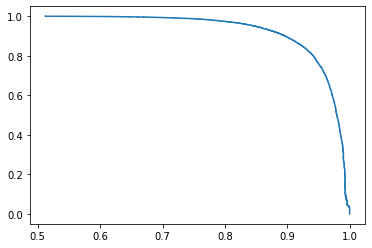

In [36]:
plt.plot(precision, recall)